In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

SAMPLE_RATE = 16384
OVERLAP_FRACTION = 0.25
FRAME_LENGTH = 128
FRAME_STEP = int(FRAME_LENGTH * (1 - OVERLAP_FRACTION))
print(FRAME_STEP)
DATASET_PATH = "training_data"
data_dir = pathlib.Path(DATASET_PATH)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'LICENSE')]
print('Commands:', commands)



96
Commands: ['marvin' 'four' 'off' 'sheila' 'three' 'on' 'one' 'tree' 'house' 'yes'
 'testing_list.txt' 'go' 'stop' 'seven' 'right' 'left'
 '_background_noise_' 'no' 'happy' 'wow' 'down' 'bed' 'two' 'eight' 'bird'
 'five' 'validation_list.txt' 'dog' 'cat' 'zero' 'up' 'six' 'nine']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)




Found 64726 files belonging to 31 classes.
Using 51781 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

#Data contains single channel audio, last dimension of the tensor can be dropped
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
#Split validation data set into validation and testing
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


(64, 16000)
(64,)
['bed' 'bed' '_background_noise_']


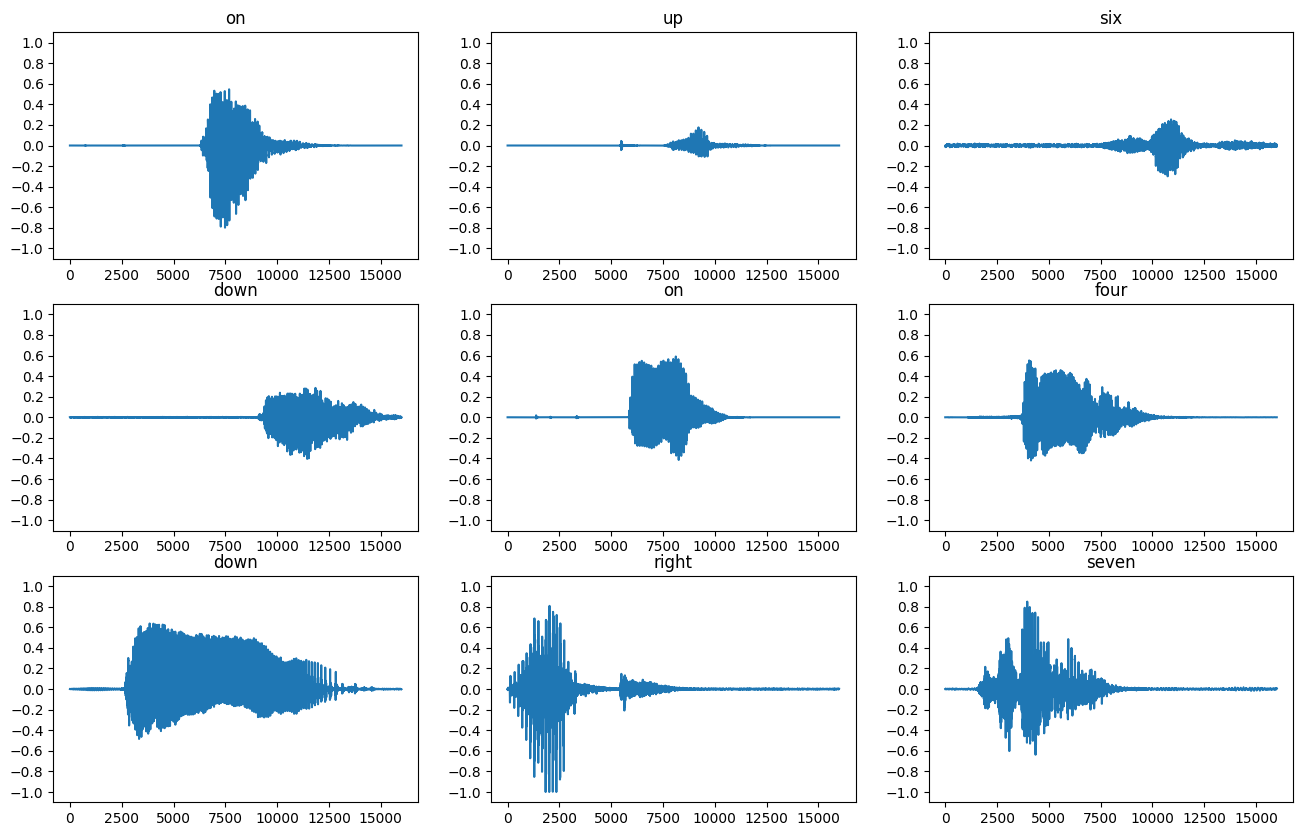

In [8]:

for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)


print(label_names[[1,1,0]])
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[int(example_labels[i])])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [10]:
for i in range(3):
  label = label_names[int(example_labels[i])]
  waveform = example_audio[i]

  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=SAMPLE_RATE))


Label: on
Waveform shape: (16000,)
Spectrogram shape: (166, 65, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (166, 65, 1)
Audio playback


Label: six
Waveform shape: (16000,)
Spectrogram shape: (166, 65, 1)
Audio playback


In [11]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


166


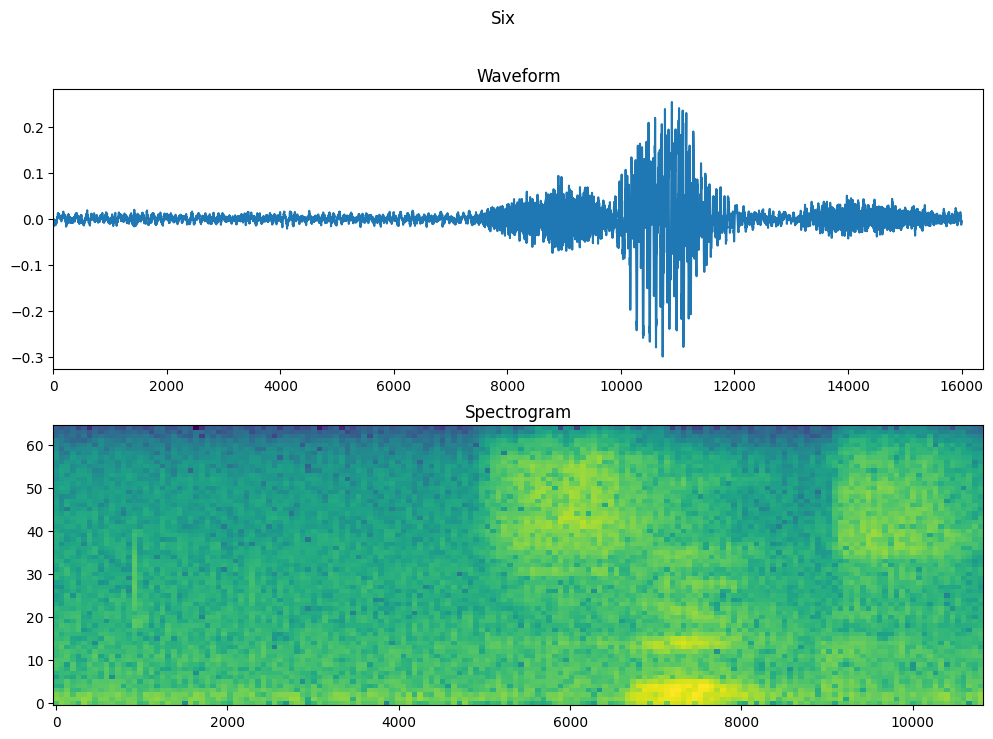

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, SAMPLE_RATE])

print(len(spectrogram.numpy()))
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [13]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
print(train_spectrogram_ds.element_spec)

(TensorSpec(shape=(None, 166, 65, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


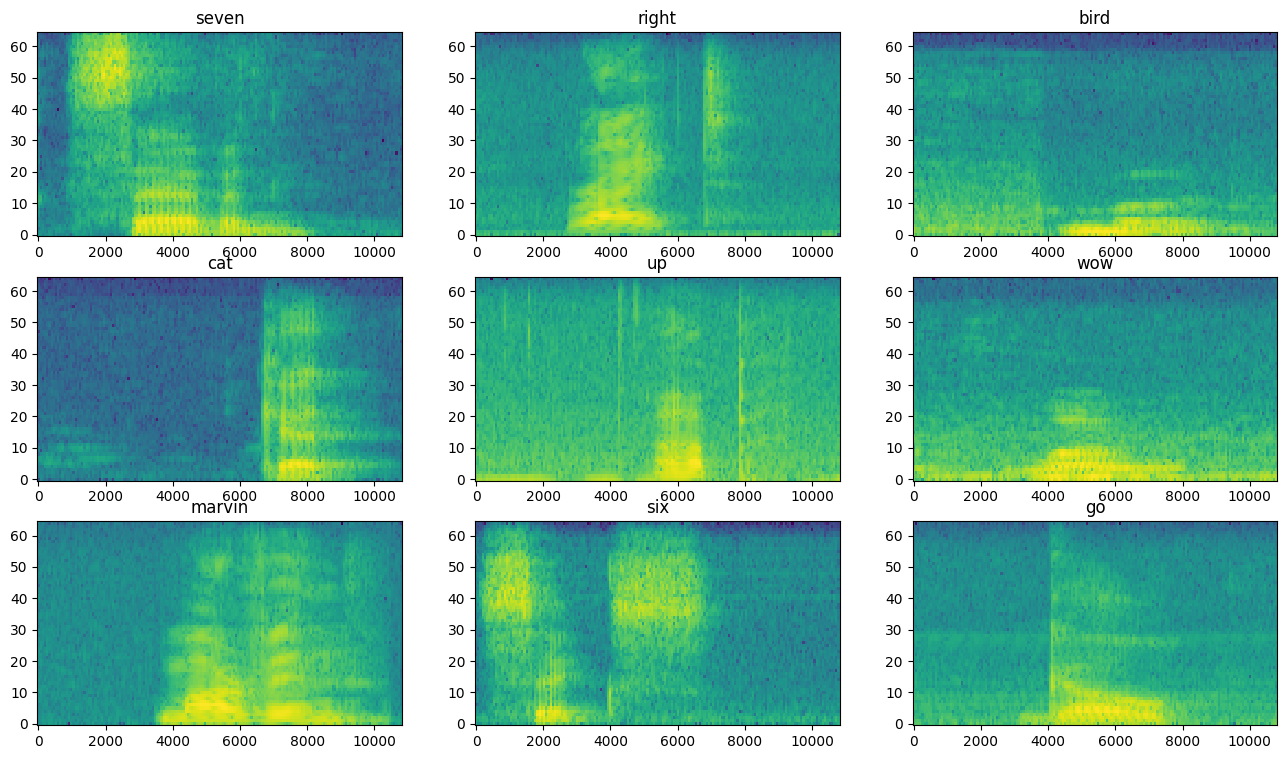

In [14]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[int(example_spect_labels[i].numpy())])

plt.show()


In [15]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = 2  # Two classes: 'zero' or 'not zero'

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),  # Output layer with softmax activation for binary classification
])

model.summary()


Input shape: (166, 65, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [17]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10


/home/petru/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-06 17:26:10.663183: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 30 which is outside the valid range of [0, 2).  Label values: 29 3 29 11 9 16 4 26 17 1 7 22 20 19 30 26 15 21 26 20 30 8 7 16 19 7 1 5 29 8 27 20 18 16 14 3 10 17 24 8 24 2 26 2 3 13 16 5 24 16 7 14 29 25 29 22 16 8 11 17 19 15 2 10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/petru/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/petru/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/home/petru/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/petru/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/petru/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/petru/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/petru/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/petru/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/petru/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_1232065/3836344365.py", line 2, in <module>

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/home/petru/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

Received a label value of 30 which is outside the valid range of [0, 2).  Label values: 29 3 29 11 9 16 4 26 17 1 7 22 20 19 30 26 15 21 26 20 30 8 7 16 19 7 1 5 29 8 27 20 18 16 14 3 10 17 24 8 24 2 26 2 3 13 16 5 24 16 7 14 29 25 29 22 16 8 11 17 19 15 2 10
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_4198]

Text(0, 0.5, 'Accuracy [%]')

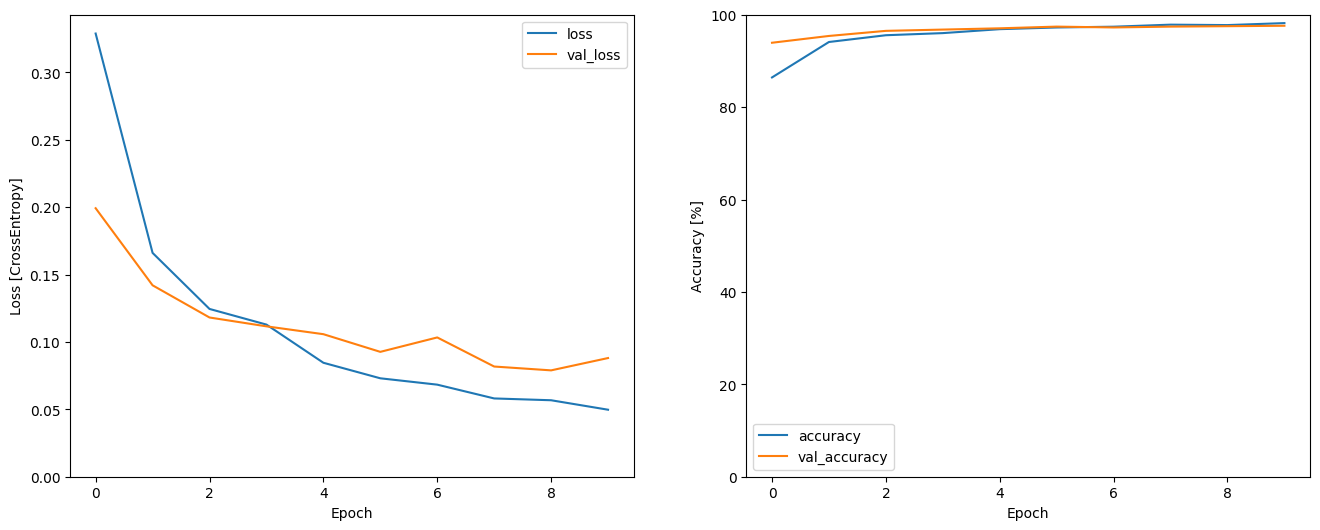

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)


18/18 [==============================] - 0s 7ms/step - loss: 0.1255 - accuracy: 0.9681


{'loss': 0.1255289614200592, 'accuracy': 0.9680948257446289}

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)


18/18 [==============================] - 0s 5ms/step


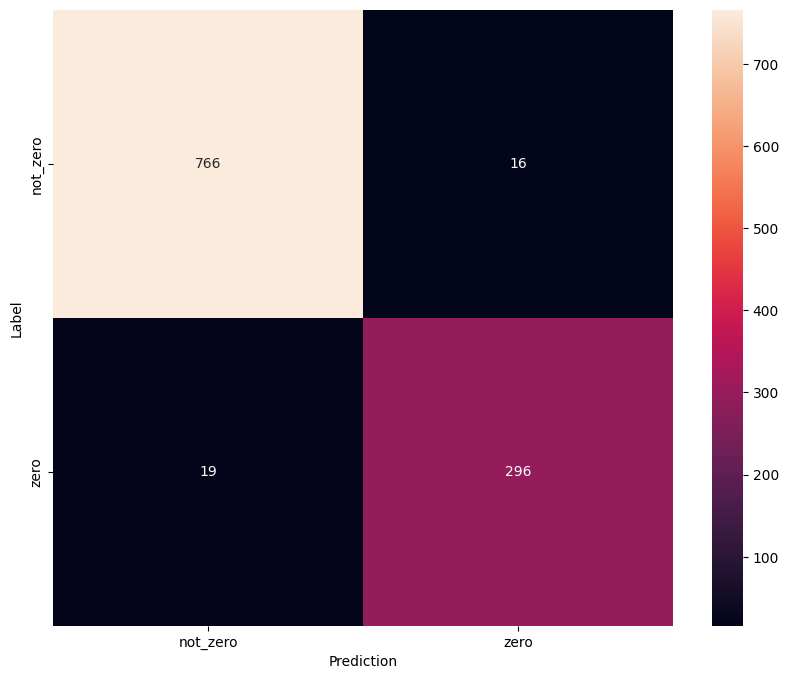

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrogram, example_spect_labels in train_spectrogram_ds.take(1):
  break

print(example_spectrogram.shape)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_gen():
    for i in range(0, len(example_spectrogram), 100):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [example_spectrogram.numpy()[i:i+100]]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


(64, 170, 65, 1)
INFO:tensorflow:Assets written to: /tmp/tmppqa174w3/assets


INFO:tensorflow:Assets written to: /tmp/tmppqa174w3/assets
/home/petru/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-01-05 21:17:35.392887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-05 21:17:35.392902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-05 21:17:35.392996: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppqa174w3
2024-01-05 21:17:35.393713: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-05 21:17:35.393720: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppqa174w3
2024-01-05 21:17:35.395831: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-05 21:17:35.428